In [1]:
## Create network model for Oxfordshire

In [2]:
# Import the following
import pandas as pd
import pandapower as pp
from pandapower.plotting import simple_plot

In [3]:
### to do

# check trafo specs -- gyubin checked
# check line specs -- gyubin checked 
# check pv gen -- multiply by capacity factor of 20%

In [4]:
# key variables
# loads
season = 0 # season = 0 for winter, where ADMD = 2kW and pv_gen is 0; season = 1 for summer, where ADMD = 75% of 2kW and pv_gen is 0.66

if season == 1:
    ADMD_MW = 2e-3*0.75
    Q_MVAR = 968.6e-6    # Power factor defined through using P²+Q²=P²/PF²
    # solar
    pv_MWp = 3.4e-3
    pv_gen = 0.66
else:
    ADMD_MW = 2e-3
    Q_MVAR = 968.6e-6
    # solar
    pv_MWp = 3.4e-3
    pv_gen = 0.0

In [5]:
# create network
net = pp.create_empty_network() 

In [6]:
# layout characteristics
start_x = 0
start_y = 0

# distance between slack bus and 132/11 trafo
dist_slack_trafo11 = 0
# distance between 132/11 trafo and first house
dist_trafo11_hh = 1    
# length of one side of household square plot
hh_side_km = 0.05
# distance between main road and first house (main road is 10m across)
dist_main_hh = 0.005
# length of a full group of 25 households (3 rows of 8 plus 1, with a 10m road)
len_hh_group = 0.455     
# space between each group of 25 households
len_bw_group = 0.01

In [7]:
# create bus dict
b = {}

In [8]:
# create bus at 132kV for grid connection
x, y = start_x, start_y
b[0] = pp.create_bus(net, vn_kv = 132, name = f"Bus 0", geodata = (x,y))

# create one grid connection point at b0
pp.create_ext_grid(net, bus=b[0], vm_pu=1.05, name = "Slack bus")

0

In [9]:
# create bus at 11kV for first step down
x, y = x + dist_slack_trafo11, y
b[1] = pp.create_bus(net, vn_kv = 11, name = f"Bus 1", geodata = (x,y))

# create one trafo b0 to b1 - from 132 to 11
hv_bus = b[0]
lv_bus = b[1]

sn_mva = 3
vn_hv_kv = 132
vn_lv_kv = 11
vk_percent = 10
vkr_percent = 1
pfe_kw = 5
i0_percent = 5

pp.create_transformer_from_parameters(net, hv_bus=hv_bus, lv_bus=lv_bus, sn_mva=sn_mva, vn_hv_kv=vn_hv_kv, vn_lv_kv=vn_lv_kv, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)

0

In [10]:
# create buses at 11kV and 415V (4 each) for second step-down transformers
for i in range(2,6):
  if i == 2:
    x, y = x + dist_trafo11_hh + len_hh_group/2, y
  else: 
    x, y = x + len_hh_group + len_bw_group, y
  b[i] = pp.create_bus(net, vn_kv = 11, name = f"Bus {i}", geodata = (x,y))
  b[i*10] = pp.create_bus(net, vn_kv = 0.415, name = f"Bus {i*10}", geodata = (x,y))

  # add bus for each of the 9 bundles up and down of the trafo grouping 25 houses
  for j in range(1,10):
    x, y = x, start_y + dist_main_hh + hh_side_km*j
    b[i*10+j] = pp.create_bus(net, vn_kv = 0.415, name = f"Bus {i*10+j}", geodata = (x,y))
    b[i*10+j+0.1] = pp.create_bus(net, vn_kv = 0.415, name = f"Bus {i*10+j+0.1}", geodata = (x,-y))
    
  # reset y for next trafo
  y = 0

In [11]:
# create four trafos - from 11kV to .415kV for b2/20, b3/30, b4/40, b5/50
sn_mva = 0.315
vn_hv_kv = 11
vn_lv_kv = 0.415
vk_percent = 10
vkr_percent = 1
pfe_kw = 1.2
i0_percent = 5

for i in range(2,6):
  hv_bus = b[i]
  lv_bus = b[i*10]
  pp.create_transformer_from_parameters(net, hv_bus=hv_bus, lv_bus=lv_bus, sn_mva=sn_mva, vn_hv_kv=vn_hv_kv, vn_lv_kv=vn_lv_kv, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)

In [12]:
# create line at 11kV from b1 to b2 to b3 to b4 to b5
r_ohm_per_km = 0.411
x_ohm_per_km = 0.131
c_nf_per_km = 0.00031
max_i_ka = 0.208

for i in range(1,5):
  from_bus = b[i]
  to_bus = b[i+1]
  if i == 1:
    length_km = dist_trafo11_hh + len_hh_group/2
  else:
    length_km = len_hh_group + len_bw_group
  pp.create_line_from_parameters(net, from_bus=from_bus, to_bus=to_bus, length_km=length_km, r_ohm_per_km=r_ohm_per_km, x_ohm_per_km=x_ohm_per_km, c_nf_per_km=c_nf_per_km, max_i_ka=max_i_ka) 

In [13]:
# create upward/downward lines at 415V from each trafo
r_ohm_per_km = 1.15     
x_ohm_per_km = 0.135
c_nf_per_km = 1e-9
max_i_ka = 0.115

for i in range(2,6):
  for j in range(1,10):
    if j == 1:
      length_km = hh_side_km + dist_main_hh
    else: 
      length_km = hh_side_km
    # upward
    from_bus = b[i*10+j-1]  
    to_bus = b[i*10+j]
    pp.create_line_from_parameters(net, from_bus=from_bus, to_bus=to_bus, length_km=length_km, r_ohm_per_km=r_ohm_per_km, x_ohm_per_km=x_ohm_per_km, c_nf_per_km=c_nf_per_km, max_i_ka=max_i_ka)     
    # downward
    if j == 1:
      from_bus = b[i*10]
    else:
      from_bus = b[i*10+j-1+0.1]  
    to_bus = b[i*10+j+0.1]
    pp.create_line_from_parameters(net, from_bus=from_bus, to_bus=to_bus, length_km=length_km, r_ohm_per_km=r_ohm_per_km, x_ohm_per_km=x_ohm_per_km, c_nf_per_km=c_nf_per_km, max_i_ka=max_i_ka) 

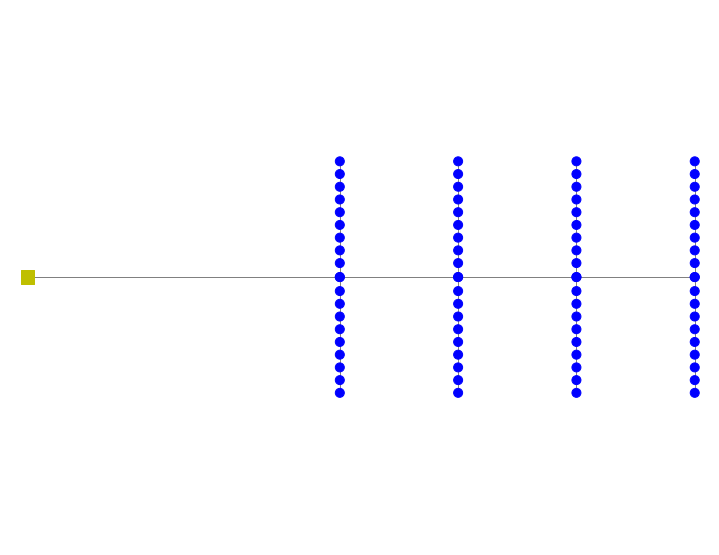

<AxesSubplot:>

In [14]:
simple_plot(net)

In [15]:
# create loads
for i in range(2,6):
  for j in range(1,10):
    if j == 9:
      p_mw = ADMD_MW
      q_mvar = Q_MVAR
    else: 
      p_mw = ADMD_MW * 3
      q_mvar = Q_MVAR * 3
    # upward
    pp.create_load(net, b[i*10+j], p_mw=p_mw, q_mvar=q_mvar)
    # downward
    pp.create_load(net, b[i*10+j+0.1], p_mw=p_mw, q_mvar=q_mvar)

In [16]:
# create pv gen
for i in range(2,6):
  for j in range(1,10):
    if j == 9:
      p_mw = (-1) * pv_MWp * pv_gen
      q_mvar = 0
    else: 
      p_mw = (-1) * pv_MWp * pv_gen * 3
      q_mvar = 0 * 3
    # upward
    pp.create_load(net, b[i*10+j], p_mw=p_mw, q_mvar=q_mvar)
    # downward
    pp.create_load(net, b[i*10+j+0.1], p_mw=p_mw, q_mvar=q_mvar)

In [17]:
# run network
pp.runpp(net, algorithm='nr');

In [18]:
# check is any bus has vm_pu below 0.9
sum(net.res_bus.vm_pu<0.9)

0

In [19]:
net.res_trafo

,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,pl_mw,ql_mvar,i_hv_ka,i_lv_ka,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree,loading_percent
0,0.446519,0.455338,-0.440051,-0.282194,0.006469,0.173144,0.002657,0.026462,1.050000,0.000000,1.036878,-0.709995,20.245711
1,0.109648,0.070450,-0.107924,-0.049360,0.001724,0.021090,0.006611,0.162997,1.034747,-0.678392,1.012918,-2.455391,39.985192
2,0.109658,0.070438,-0.107935,-0.049361,0.001723,0.021077,0.006615,0.163111,1.034141,-0.669391,1.012301,-2.448713,40.009269
3,0.109665,0.070430,-0.107942,-0.049362,0.001723,0.021068,0.006617,0.163187,1.033737,-0.663386,1.011889,-2.444259,40.025345
4,0.109669,0.070426,-0.107946,-0.049363,0.001722,0.021063,0.006619,0.163225,1.033535,-0.660381,1.011683,-2.442031,40.033391


In [20]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.050000,0.000000,-0.446519,-0.455338
1,1.036878,-0.709995,0.000000,0.000000
2,1.034747,-0.678392,0.000000,0.000000
3,1.012918,-2.455391,0.000000,0.000000
4,0.992325,-2.071339,0.006000,0.002906
...,...,...,...,...
77,0.925071,-0.725215,0.006000,0.002906
78,0.922008,-0.659384,0.006000,0.002906
79,0.922008,-0.659384,0.006000,0.002906
80,0.921242,-0.642858,0.002000,0.000969


In [21]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,0.440051,0.282194,-0.438991,-0.281856,0.001060,3.377826e-04,0.026462,0.026462,0.026462,1.036878,-0.709995,1.034747,-0.678392,12.722084
1,0.329343,0.211406,-0.329117,-0.211334,0.000226,7.200775e-05,0.019851,0.019851,0.019851,1.034747,-0.678392,1.034141,-0.669391,9.543797
2,0.219459,0.140896,-0.219359,-0.140864,0.000100,3.201091e-05,0.013236,0.013236,0.013236,1.034141,-0.669391,1.033737,-0.663386,6.363597
3,0.109694,0.070434,-0.109669,-0.070426,0.000025,7.999946e-06,0.006619,0.006619,0.006619,1.033737,-0.663386,1.033535,-0.660381,3.182118
4,0.053962,0.024680,-0.052701,-0.024532,0.001260,1.479501e-04,0.081498,0.081498,0.081498,1.012918,-2.455391,0.992325,-2.071339,70.868113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.014128,0.006795,-0.014033,-0.006784,0.000095,1.112682e-05,0.023441,0.023441,0.023441,0.930424,-0.839378,0.925071,-0.725215,20.383336
72,0.008033,0.003878,-0.008002,-0.003875,0.000031,3.644231e-06,0.013415,0.013415,0.013415,0.925071,-0.725215,0.922008,-0.659384,11.665211
73,0.008033,0.003878,-0.008002,-0.003875,0.000031,3.644231e-06,0.013415,0.013415,0.013415,0.925071,-0.725215,0.922008,-0.659384,11.665211
74,0.002002,0.000969,-0.002000,-0.000969,0.000002,2.280486e-07,0.003356,0.003356,0.003356,0.922008,-0.659384,0.921242,-0.642858,2.918121
